# Synchronisation
- When merging time-dependent data from different sources, matching them well is important, but also comes with some choices.
- If time series are to be used in Machine Learning, exact synchronisation is usually needed, i.e., equal timestamps on each variable.
- For plotting purposes different time resolution, e.g., weeks vs months, may not be a problem as long as the different cycles match up.

In [1]:
# Create a time series with a frequency of 1 hour and a length 72*24 hours
import pandas as pd
import numpy as np

rng = np.random.default_rng(1979)
stock = rng.standard_normal(72).cumsum() + 2
days = pd.date_range('2021-01-01', periods=72, freq='D')

rng2 = np.random.default_rng(1000)
electricity = rng2.standard_normal(72*24).cumsum()+30
hours = pd.date_range('2021-01-01', periods=72*24, freq='H')

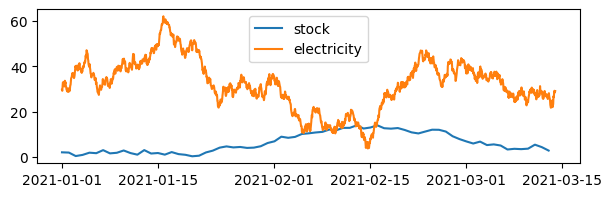

In [2]:
# Plot the two series in the same plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 2))
ax.plot(days, stock, label='stock')
ax.plot(hours, electricity, label='electricity')
ax.legend()
plt.show()

## Accumulation
- If a higher resolution time series is to be synchronized with a lower resolution series, some type of accumulation needs to be done.
- Things to keep in mind:
    - Which type of accumulation should be done, e.g., sum for count data, mean for intensity data?
    - Should we use simple statistics, robust statistics or smoothed series data?
    - Are the low resolution recordings a series of snapshots (a) or an accumulation between (before (b)/after (d)) or around (c) timepoints (see illustration)?  
      - This coresponds to the different uses of filters in the [Noise reduction section](../1_Signal/2_Noise_reduction.ipynb).
      - ... which also means that it is possible to echange simple averages with other smoothers.

<img src="../../images/Accumulation.png" width="700px">

In [3]:
# Turn the hourly series into a daily series by taking the mean of each day
daily2 = electricity.reshape(72, 24).mean(axis=1)
print(daily2.shape)
daily2[:5]

(72,)


array([30.97322385, 34.35672352, 39.15225169, 42.54404014, 36.29402279])

__Question:__ Is the mean calculation above an accumulation of type a, b, c or d (as compared to the illustration)?

In [4]:
# Make a dataframe of days and daily
df_days = pd.DataFrame({'days': days, 'stock': stock})
# .. and hours and hourly
df_hours = pd.DataFrame({'hours': hours, 'electricity': electricity})
df_hours.head()

,hours,electricity
0,2021-01-01 00:00:00,29.678670
1,2021-01-01 01:00:00,29.193008
2,2021-01-01 02:00:00,30.873066
3,2021-01-01 03:00:00,32.843593
4,2021-01-01 04:00:00,32.998777


In [5]:
# Group the hourly series by day and take the mean of each day
daily3 = df_hours.electricity.groupby(df_hours.hours.dt.date).mean()
daily3.name = 'electricity' # <- Will be column name in dataframe

# Change name of index to days
daily3.index.name = 'days'

# Convert index to datetime
daily3.index = pd.to_datetime(daily3.index) # <- Important for matching with other datetimes!
daily3.head()

days
2021-01-01    30.973224
2021-01-02    34.356724
2021-01-03    39.152252
2021-01-04    42.544040
2021-01-05    36.294023
Name: electricity, dtype: float64

In [6]:
# Concatenate the daily series and the daily3 series
daily4 = pd.concat([pd.DataFrame({"stock":stock}, index=days), daily3], axis=1)
daily4

,stock,electricity
2021-01-01,1.954335,30.973224
2021-01-02,1.844837,34.356724
2021-01-03,0.304523,39.152252
2021-01-04,0.812667,42.544040
2021-01-05,1.796910,36.294023
...,...,...
2021-03-09,3.365346,26.623594
2021-03-10,3.576303,28.499956
2021-03-11,5.343604,27.881922
2021-03-12,4.259951,27.112489


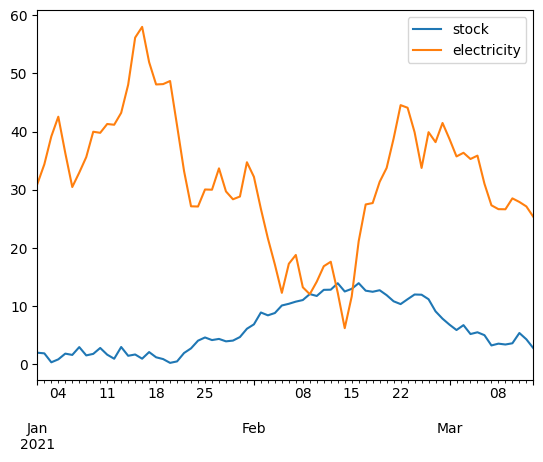

In [7]:
# Plot the two time series in daily4 using Pandas plot
daily4.plot()
plt.show()

## Interpolation
- Timepoints may not match as easily as with days and hours above.
- If one series is shifted slightly, the series are irregular in timesteps or have non-intuitive intervals, interpolation is an alternative.
- When interpolating an irregular sequence in Pandas, one may need to resample to a higher frequency, fill the missing values and resample to the final frequency (see example below).

In [8]:
# Create a time series with irregular frequency
irr_dates = pd.date_range('2000-01-01 00:00', periods=365, freq='D') # <- Higher accuracy applied here to enable sampling

# Sample 50 random dates from irr_dates
m = np.arange(0,365,1)
rng.shuffle(m)
irr_dates = irr_dates[np.sort(m[:50])].sort_values()

# Create a series with random values and the sampled dates as index
irr_series = pd.DataFrame({'values': rng.standard_normal(50)}, index=irr_dates)
irr_series.head()

,values
2000-01-04,0.490463
2000-01-07,1.274086
2000-01-08,-0.485563
2000-01-19,0.886186
2000-01-21,-0.331479


In [9]:
# Interpolate the series to weekly frequency without intermediate resampling
weekly = irr_series.resample('W').interpolate("linear")
weekly.head()

,values
2000-01-09,NaN
2000-01-16,NaN
2000-01-23,NaN
2000-01-30,0.477419
2000-02-06,0.552430


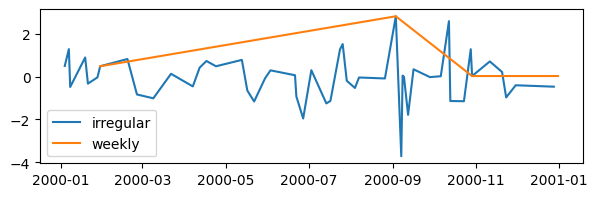

In [10]:
# Plot the two series
fig, ax = plt.subplots(figsize=(7, 2))
ax.plot(irr_series, label='irregular')
ax.plot(weekly, label='weekly')
ax.legend()
plt.show()

In [11]:
# Interpolate the series to weekly frequency after resampling to daily frequency
weekly = irr_series.resample('D').interpolate("linear").resample('W').interpolate("linear")
weekly.head()

,values
2000-01-09,-0.360859
2000-01-16,0.512072
2000-01-23,-0.248126
2000-01-30,0.477419
2000-02-06,0.595284


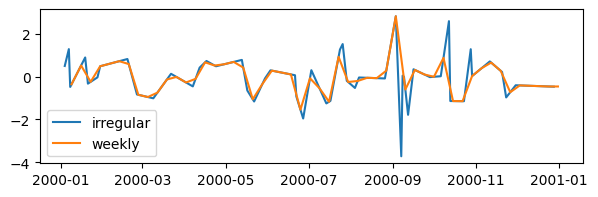

In [12]:
# Plot the two series
fig, ax = plt.subplots(figsize=(7, 2))
ax.plot(irr_series, label='irregular')
ax.plot(weekly, label='weekly')
ax.legend()
plt.show()

## Time delays
- Industrial processes often have a continuous or batchwise handling of raw materials into other materials or products.
  - When sensors record data along the production line, matching a piece of raw material to sensor readings can be done by adding a delay to the timestamp of the measurements early in the process or subtracting time from the later measurements.
- For some processes, the delay is a known, fixed quantity. 
  - For others the delay may be dependent on dynamic factors like raw material properties or process settings that add uncertainty to the time delay.
  - Synchronising such data, may require optimising correlations between sensors or using more advanced warping techniques.
  
<img src="../../images/Industrial_process.png" width="700px">

## Resources
- [Pandas groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)
- [Pandas interpolation](https://pandas.pydata.org/docs/reference/api/pandas.core.resample.Resampler.interpolate.html)